In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.croco_drifter as cdr
import scipy.interpolate as interpolate
from sklearn.utils import resample

In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=2)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [4]:
root_path = '/home/datawork-lops-osi/equinox/jetn/old/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'
output_dir = root_path+run+'diagnostics/autocorr/'

In [5]:
import dask.bag as db
files = [f for f in sorted(glob(output_dir+'uu_40av*')) if 'mean.csv' not in f]
b = db.from_sequence(files, partition_size=1)

In [10]:
file = root_path+run+'diagnostics/autocorr/uu_40av*'
b = b.filter(lambda file: os.path.getsize(file)>0)

In [11]:
df_mean = pd.read_csv(output_dir+'mean.csv', sep='\t')

# lags
lags = df_mean.columns[1:]

# mapping from mid to interval
def get_interval(y):
    return pd.Interval(*map(float, y[1:-1].split(',')))

y_bin = df_mean['y_cut'].apply(get_interval)
y_mid = y_bin.apply(lambda y: y.mid).rename('y_mid')
df_y = pd.concat([y_mid, y_bin], axis=1).set_index('y_mid')

df_y.loc[25.]

y_cut    (0.0, 50.0]
Name: 25.0, dtype: interval

In [13]:
def load_and_process(file,myfunc,**kwargs_myfunc):
    df = pd.read_csv(file, sep='\t', header=None)
            # rename columns
            #df = df.rename(columns={i-1:float(c) for i, c in enumerate(lags)})
    df = df.rename(columns={i:c for i, c in enumerate(lags)})
            #except:
            #    df = pd.DataFrame(np.nan, index=[0,], columns=lags)

            # get interval
    y_mid = float(file.split('/')[-1].split('_')[-1])
    y_bin = df_y.loc[y_mid][0]

            # compute mean
    df_out = myfunc(df,**kwargs_myfunc)
    #df_out = pd.concat([pa,ci_low,ci_upp],axis='index')
    #df_out = pd.DataFrame(np.array([ci[0].values]))#,columns=[V+'_lower' for V in pa.index.values],index=y_bin)
    #df_out = df.mean(axis=0).to_dict()
    df_out['y_cut'] = y_bin
    return df_out.to_dict()

In [6]:
from inspect import signature
from scipy import signal
import scipy
def param_fit(x,myfunc,bounds,X = 'normalized'):
    """Find the best fit using the function myfunc. The parameters are computed fitting the data using myfunc 
    to the average over all segments for each draws.
    Parameters
    ----------
        x : DataArray
            Correaltionfunction to fit
        myfunc: func
                Function used for the fit
        var : str
              variable to fit
        X : str
            If X='Normalized', the fit will be made on normalized autocorrelation function
        name: str, optional
    
    Returns
    ----------
    out : Dataset
          Dataset containing the parameters fitted using myfunc for all draws.
    """
    sig = signature(myfunc)
    
    if X=='normalized':
        _x = x/x.loc[0] 
    else :
        _x = x
 #   pa = np.full((1,len(sig.parameters)-1),np.nan)
    pa,co = scipy.optimize.curve_fit(myfunc,_x.index,_x,bounds=bounds)
    #    err[i,:] = np.abs(pa[i,:]-true_val)/true_val
    
    out = pd.DataFrame(pa,index=[V for V in sig.parameters.keys()][1:],columns=[x.name])
#    out.attrs = {'time window ' : DT,'number of segments' : nT}
    return out

In [7]:
def bootstrap(df,B,alpha):
    dfm = df.mean('index')
    dfm.index = dfm.index.astype(float)
    pa = param_fit(dfm,myfunc,bounds,X='')
    out = pa.copy()
    for i in range(B):
        dfc = df.copy()
        df_sample = dfc.sample(frac=1,replace=True,axis='index').mean('index')
        df_sample.index = df_sample.index.astype(float)
        pa_sample = param_fit(df_sample,myfunc,bounds,X='')

        out = pd.concat([out,pa_sample],axis='columns')
    deltastar = out.sub(pa,axis='index')
    q = deltastar.iloc[:,1:].quantile([alpha,1-alpha], axis='columns')
    deltau = q.iloc[0]
    deltal = q.iloc[1]
    ci_low = pa.sub(deltal,axis='index').rename(index={V : V+'_low' for V in pa.index.values})
    ci_upp = pa.sub(deltau,axis='index').rename(index={V : V+'_upp' for V in pa.index.values})
    val = np.hstack([pa.values.reshape(pa.size,),ci_low.values.reshape(ci_low.size,),ci_upp.values.reshape(ci_upp.size,)])
    index = np.hstack([pa.index,ci_low.index,ci_upp.index])
    df_out = pd.Series(val,index=index)
    return df_out

In [29]:
om = 2 # tidal frequency (M2)
# Fast contribution
def Ctilde(t,Tt):
    return np.exp(-t/Tt)*np.cos(2*np.pi*om*t)#*np.cos(2*np.pi*nu*t)
#Slow contribution
def Cbar(t,Tb,Om):
    return np.exp(-t/Tb)*np.cos(2*np.pi*Om*t)
#Total formula
def C(t,Tt,Xtilde,Tb,Xbar,Omega):
    return Xbar*Cbar(t,Tb,Omega)+Xtilde*Ctilde(t,Tt)

In [30]:
# Parameters fit
myfunc = C # model to use in the fit
sig = signature(myfunc)
bounds = ((1,0,0,0,0),(np.inf,np.inf,np.inf,np.inf,1)) # bounds
Nparams = len([V for V in sig.parameters.keys()][1:]) # Number of parameters to fit

In [31]:
_meta = [(l, str) for l in sig.parameters.keys()][1:]+[(l+'_low', str) for l in sig.parameters.keys()][1:]+[(l+'_upp', str) for l in sig.parameters.keys()][1:]+[('y_cut', y_bin.dtype)]
df = b.map(load_and_process,bootstrap,**{'B' : 100,'alpha' : 0.05}).to_dataframe(meta=_meta).compute()

In [32]:
df['y_mid'] = df.y_cut.map(lambda v : v.mid)

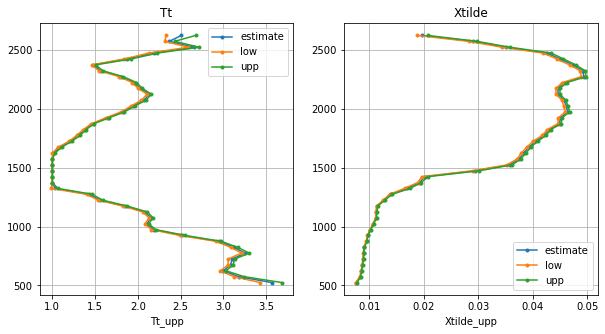

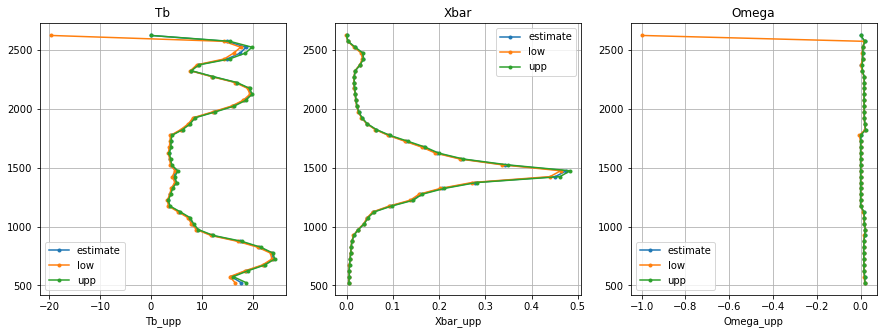

In [34]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for V, ax in zip(['Tt','Xtilde'],axs):
    df.plot(x=V,y='y_mid',ax=ax,marker='.',label='estimate')
    df.plot(x=V+'_low',y='y_mid',marker='.',ax=ax,label='low')
    df.plot(x=V+'_upp',y='y_mid',marker='.',ax=ax,label='upp')
    ax.legend();ax.set_title(V);ax.grid()
fig,axs = plt.subplots(1,3,figsize=(15,5))
for V, ax in zip(['Tb','Xbar','Omega'],axs):
    df.plot(x=V,y='y_mid',marker='.',ax=ax,label='estimate')
    df.plot(x=V+'_low',y='y_mid',marker='.',ax=ax,label='low')
    df.plot(x=V+'_upp',y='y_mid',marker='.',ax=ax,label='upp')
    ax.legend();ax.set_title(V);ax.grid()

### Without $\Omega$

In [35]:
#Slow contribution
def Cbar(t,Tb):
    return np.exp(-t/Tb)#*np.cos(2*np.pi*Om*t)
#Total formula
def C(t,Tt,Xtilde,Tb,Xbar):
    return Xbar*Cbar(t,Tb)+Xtilde*Ctilde(t,Tt)

In [36]:
# Parameters fit
myfunc = C # model to use in the fit
sig = signature(myfunc)
bounds = ((1,0,0,0),np.inf) # bounds
Nparams = len([V for V in sig.parameters.keys()][1:]) # Number of parameters to fit

In [40]:
_meta = [(l, str) for l in sig.parameters.keys()][1:]+[(l+'_low', str) for l in sig.parameters.keys()][1:]+[(l+'_upp', str) for l in sig.parameters.keys()][1:]+[('y_cut', y_bin.dtype)]
df = b.map(load_and_process,bootstrap,**{'B' : 1000,'alpha' : 0.05}).to_dataframe(meta=_meta).compute()

In [41]:
df['y_mid'] = df.y_cut.map(lambda v : v.mid)

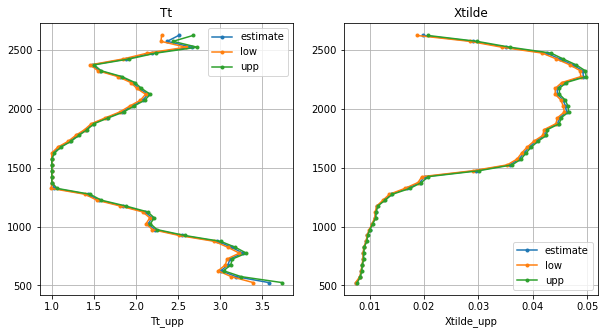

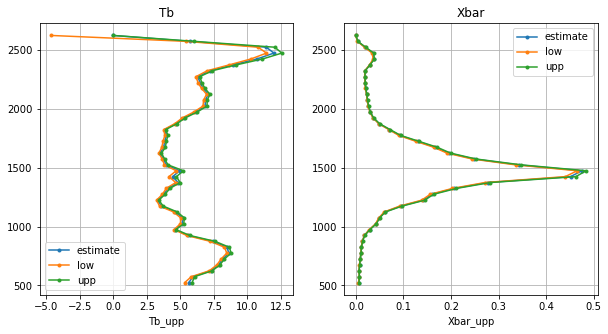

In [42]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for V, ax in zip(['Tt','Xtilde'],axs):
    df.plot(x=V,y='y_mid',ax=ax,marker='.',label='estimate')
    df.plot(x=V+'_low',y='y_mid',marker='.',ax=ax,label='low')
    df.plot(x=V+'_upp',y='y_mid',marker='.',ax=ax,label='upp')
    ax.legend();ax.set_title(V);ax.grid()
fig,axs = plt.subplots(1,2,figsize=(10,5))
for V, ax in zip(['Tb','Xbar'],axs):
    df.plot(x=V,y='y_mid',marker='.',ax=ax,label='estimate')
    df.plot(x=V+'_low',y='y_mid',marker='.',ax=ax,label='low')
    df.plot(x=V+'_upp',y='y_mid',marker='.',ax=ax,label='upp')
    ax.legend();ax.set_title(V);ax.grid()

In [43]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
